# Dimensionnement de la cuve

$$
\textbf{Méthode de Référence - NF P16-005}
$$

Le coefficient de référence est défini comme :

$$
C_{\text{ref}} = \frac{V_{\text{pluie}}}{V_{\text{besoin}}}
$$

où :

- $V_{\text{pluie}}$ est le volume d'eau de pluie récupérable sur la période considérée.
- $V_{\text{besoin}}$ est le volume d'eau non potable requis pour l'usage prévu.

Si $C_{\text{ref}} \geq 0.65$, alors le volume de stockage est donné par :

$$
V_{\text{ref}} = f(C_{\text{ref}}, V_{\text{besoin}})
$$

Sinon, si $C_{\text{ref}} < 0.65$, alors on applique une simulation basée sur le modèle Jenkins, adaptée à une échelle mensuelle :

$$
V_{\text{cuve}} = g(V_{\text{pluie}}, V_{\text{besoin}}, \text{paramètres simulation})
$$

Avec :

- $V_{\text{ref}}$ : volume de référence pour le stockage.
- $V_{\text{cuve}}$ : volume de la cuve dimensionnée par la simulation.
- $f$ et $g$ représentant les fonctions de calcul selon la norme et le modèle de simulation.



In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_monthly_precipitation_data(gid, data_folder, years_to_keep):
    """
    Charge les données mensuelles pour la station GID (format JSON).
    Retourne un DataFrame (year, month, PRELIQ_mm).
    """
    file_path = os.path.join(data_folder, f"{gid}.json")
    if not os.path.exists(file_path):
        return None
    
    with open(file_path, "r", encoding="utf-8") as f:
        safran_data = json.load(f)

    months_data = safran_data.get("months", {})
    rows = []
    for date_str, values in months_data.items():
        y_str, m_str = date_str.split("-")
        if y_str in years_to_keep:
            row = {
                "year": int(y_str),
                "month": int(m_str),
                "PRELIQ_mm": values.get("monthly_PRELIQ_Q", 0.0)
            }
            rows.append(row)

    df = pd.DataFrame(rows)
    if df.empty:
        return None
    df.sort_values(["year","month"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [3]:
def build_monthly_timeseries_for_year(df, year):
    """ Extrait (month, PRELIQ_mm) pour 'year'. """
    dfy = df[df["year"] == year].copy()
    return dfy[["month","PRELIQ_mm"]].reset_index(drop=True)

In [4]:
def build_monthly_timeseries_average(df):
    """
    Construit la série moyenne mensuelle: groupby("month") -> mean.
    Retourne (month, PRELIQ_mm).
    """
    df_avg = df.groupby("month")["PRELIQ_mm"].mean().reset_index()
    return df_avg[["month","PRELIQ_mm"]]

$$
\textbf{Paramètres et Variables}
$$

- $B_m$ : besoin mensuel pour le mois $m$, en litres.
- $P_{r,m}$ : volume de pluie récupérable au mois $m$, en litres.

On applique la formule :

$$
P_{r,m} = K \times S \times \left(P_m \times 10^{-3} \right)
$$

si $P_m$ est en mm et $S$ en m².  
(En litres, on multiplierait par $1000$)

- $C_{\text{ref}}$ : le coefficient de référence.
- $V_{\text{ref}}$ : le volume de référence calculé selon la norme NF P16-005, en m³ (ou L).
- $V$ : le volume de la cuve (variable lors de la simulation).

$$
\textbf{Calcul de } C_{\text{ref}}
$$

La norme NF P16-005 définit le coefficient de référence (pour 60 mois) comme :

$$
C_{\text{ref}} = \frac{1}{60} \sum_{m=1}^{60} \min \left( 1, \frac{P_{r,m}}{B_m} \right)
$$

$$
\textbf{Interprétation :}
$$

- On regarde, mois par mois, le rapport de la pluie récupérable $P_{r,m}$ au besoin $B_m$.
- On prend la valeur minimale entre ce ratio et $1$.
- On fait la moyenne sur $60$ mois.



In [5]:
def compute_C_ref(df, usage_L_month, S, K):
    """
    Calcule C_ref selon NF P16-005 en version mensuelle:
    """
    if df is None or df.empty:
        return 0.0
    alpha_sum = 0.0
    for _, row in df.iterrows():
        P_mm = row["PRELIQ_mm"]
        P_r = P_mm * S * K 
        ratio = 0.0
        if usage_L_month > 0:
            ratio = P_r / usage_L_month
        alpha_m = min(1.0, ratio)
        alpha_sum += alpha_m
    return alpha_sum / len(df)

$$
\textbf{Décision en fonction de } C_{\text{ref}}
$$

Si $C_{\text{ref}} < 0.65$ :

- La méthode de référence n’est pas applicable.
- Il faut alors recourir à une simulation plus fine (voir partie 3).

Si $C_{\text{ref}} \geq 0.65$ :

- On peut appliquer la formule de dimensionnement :

$$
V_{\text{ref}} = \frac{\sum_{m=1}^{n} B_m}{60} \times \frac{0.7}{C_{\text{ref}}^2}
$$

ou, sous une autre forme :

$$
V_{\text{ref}} = \left( \frac{\sum_{m=1}^{n} B_m}{60} \right) \times \frac{0.7}{C_{\text{ref}}^2}
$$


On obtient ainsi un volume de stockage simplifié, valable si $C_{\text{ref}} \geq 0.65$.


In [6]:
def compute_volume_ref(df, usage_L_month, C_ref):
    """
    Si C_ref >= 0.65 => calcul du volume de référence NF P16-005
    """
    B_moy   = (usage_L_month * len(df)) / len(df)
    V_ref   = B_moy * (0.7 / (C_ref**2))
    return V_ref

$$
\textbf{Simulation (adaptation mensuelle du modèle Jenkins)}
$$

Lorsque $C_{\text{ref}} < 0.65$, on effectue une simulation.

### Variables pour la simulation (mensuelle)

- $B_m$ : besoin mensuel en eau de pluie non potable.
- $P_{r,m}$ : pluie récupérable dans le mois $m$.
- $V_{\text{cuve}}(m)$ : volume d’eau de pluie dans la cuve en fin du mois $m$.
- $V_{\max}$ : capacité (volumétrique) de la cuve

### Algorithme (pas mensuel)

On note, pour chaque mois $m$ :

$$
V^{\sim} = V_{\text{cuve}}(m-1) + P_{r,m}
$$

On additionne l’eau de la cuve restant en fin du mois précédent et la pluie récoltée ce mois.

#### Débordement (si $V^{\sim} > V_{\max}$) :

$$
V^{\sim} \leftarrow \min(V^{\sim}, V_{\max})
$$

#### Soutirage (besoin mensuel $B_m$) :

$$
S_m = \min(V^{\sim}, B_m)
$$

Le volume soutiré ne peut excéder $V^{\sim}$.

#### Nouveau volume dans la cuve :

$$
V_{\text{cuve}}(m) = V^{\sim} - S_m
$$

On cumule le volume soutiré $S_m$ sur tous les mois $m=1\ldots n$ pour connaître la quantité totale d’eau de pluie réellement utilisée.

### Calcul du taux de couverture

Une fois la simulation terminée (sur $n$ mois), on obtient :

$$
\text{Taux de couverture}(V_{\max}) = \frac{\sum_{m=1}^{n} S_m}{\sum_{m=1}^{n} B_m} \times 100\%
$$

En faisant varier $V_{\max}$ (de $Capacite_{\min}$ à, par exemple, $Capacite_{\max}$ m³), on trace la courbe $TC(V_{\max})$.  
On identifie alors :

- **Année défavorable** : cumul minimal (trace la courbe la plus basse).
- **Année favorable** : cumul maximal (trace la courbe la plus haute).
- **Année moyenne** : moyenne des précipitations.

On obtient une enveloppe de trois courbes avec :

- Année **la plus favorable**.
- Année **la moins favorable**.
- Année **moyenne**.

On peut alors définir une **“zone d’optimum”** (pour un certain intervalle de taux de couverture et calculer un **volume “idéal”** pour le dimensionnement da la cuve


In [7]:
def simulate_tank_monthly(df_month, S, K, usage_L_month, tank_capacity_L):
    """
    Modèle de simulation mensuel (type Jenkins).
    """
    if df_month is None or df_month.empty:
        return 0.0
    
    total_usage = usage_L_month * len(df_month)

    volume_cuve = 0.0
    total_utilise = 0.0

    for _, row in df_month.iterrows():
        P_mm = row["PRELIQ_mm"]
        P_r = P_mm * S * K
        tmp = volume_cuve + P_r
        if tmp> tank_capacity_L:
            tmp = tank_capacity_L
        soutirage = min(tmp, usage_L_month)
        total_utilise += soutirage
        volume_cuve = tmp - soutirage

    if total_usage<=0:
        return 0.0
    return (total_utilise/total_usage)*100.0

In [8]:
def coverage_curve_for_scenario(df_month, S, K, usage_L_month,
                                       min_capacity_L, max_capacity_L, step_L):
    """
    Balaye Vmax entre min_capacity_L et max_capacity_L par un pas de step_L
    => DataFrame: (Vmax_L, taux_couverture_%).
    """
    cap_range = np.arange(min_capacity_L, max_capacity_L+step_L, step_L)
    results = []
    for capacityL in cap_range:
        tc = simulate_tank_monthly(df_month, S, K, usage_L_month, capacityL)
        results.append({"Vmax_L": capacityL, "taux_couverture_%": tc})
    return pd.DataFrame(results)

In [ ]:
gid = 20
years_to_keep = ["2020","2021","2022","2023","2024"]

# Ex: usage 3000 L/mois = 3 m³/mois
usage_L_month = 3000.0
S = 50.0    # 50 m²
K = 0.8

# Balayage en L: par ex. 500..10000 L
min_capacity_L=500
max_capacity_L=10000
step_L=500 # Besoin moyenne en Litre par jour

try:
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    script_dir = os.getcwd()

base_data_dir = os.path.join(script_dir, "public", "data")
data_folder   = os.path.join(base_data_dir, "FR-ID-JSON")

##  Chargement des données

In [11]:
df_precip = load_monthly_precipitation_data(gid, data_folder, years_to_keep)
if df_precip is None or df_precip.empty:
    print(f"Aucune donnée mensuelle pour GID={gid}")
    exit()
print(f"{len(df_precip)} mois chargés pour GID={gid}")
df_precip

60 mois chargés pour GID=20


,year,month,PRELIQ_mm
0,2020,1,85.2
1,2020,2,106.9
2,2020,3,58.2
3,2020,4,51.3
4,2020,5,31.1
5,2020,6,91.2
6,2020,7,23.8
7,2020,8,82.0
8,2020,9,43.0
9,2020,10,132.4


## Calcul de C_ref

In [13]:
c_ref = compute_C_ref(df_precip, usage_L_month, S, K)
print(f"C_ref = {c_ref:.3f}")

if c_ref >= 0.65:
    v_ref = compute_volume_ref(df_precip, usage_L_month, c_ref)
    print(f"Volume de la cuve (V_ref) ={v_ref:.2f} m³")
# => Sinon, simulation
#print("C_ref<0.65 => simulation mensuelle (Jenkins).")

C_ref = 0.734
Volume de la cuve (V_ref) =3895.51 m³


## Simulation mensuelle (Jenkins)

In [14]:
# On choisit une valeur de C_ref inférieur 0.65

c_ref = 0.60
print("C_ref<0.65 => simulation mensuelle (Jenkins).")

C_ref<0.65 => simulation mensuelle (Jenkins).


## Identification  année défavorable et favorable

In [17]:

annual_sums = df_precip.groupby("year")["PRELIQ_mm"].sum().reset_index()
worst_year = annual_sums.loc[annual_sums["PRELIQ_mm"].idxmin(),"year"]
best_year  = annual_sums.loc[annual_sums["PRELIQ_mm"].idxmax(),"year"]
print(f"Année défavorable={worst_year}, favorable={best_year}")

Année défavorable=2022, favorable=2020


## Couvertures (défavorable, moyenne, favorable)

In [18]:
df_worst = build_monthly_timeseries_for_year(df_precip, worst_year)
df_best  = build_monthly_timeseries_for_year(df_precip, best_year)
df_mean  = build_monthly_timeseries_average(df_precip)

cov_worst = coverage_curve_for_scenario(
    df_worst, S, K, usage_L_month, min_capacity_L, max_capacity_L, step_L
)
cov_best  = coverage_curve_for_scenario(
    df_best,  S, K, usage_L_month, min_capacity_L, max_capacity_L, step_L
)
cov_mean  = coverage_curve_for_scenario(
    df_mean,  S, K, usage_L_month, min_capacity_L, max_capacity_L, step_L
)


print("Cov Worst:\n", cov_worst)
print("Cov Best:\n", cov_best)
print("Cov Mean:\n", cov_mean)

Cov Worst:
     Vmax_L  taux_couverture_%
0      500          15.855556
1     1000          29.900000
2     1500          41.300000
3     2000          51.022222
4     2500          58.500000
5     3000          63.366667
6     3500          63.366667
7     4000          63.366667
8     4500          63.366667
9     5000          63.366667
10    5500          63.366667
11    6000          63.366667
12    6500          63.366667
13    7000          63.366667
14    7500          63.366667
15    8000          63.366667
16    8500          63.366667
17    9000          63.366667
18    9500          63.366667
19   10000          63.366667
Cov Best:
     Vmax_L  taux_couverture_%
0      500          16.666667
1     1000          33.200000
2     1500          47.766667
3     2000          60.877778
4     2500          71.655556
5     3000          80.277778
6     3500          84.933333
7     4000          86.733333
8     4500          88.122222
9     5000          88.633333
10    5500       

In [ ]:
# x= Vmax_L, y= coverage
x_worst, y_worst = cov_worst["Vmax_L"].values, cov_worst["taux_couverture_%"].values
x_best,  y_best  = cov_best["Vmax_L"].values,  cov_best["taux_couverture_%"].values
x_mean,  y_mean  = cov_mean["Vmax_L"].values,  cov_mean["taux_couverture_%"].values

print("x Worst:\n", x_worst)
print("x Worst:\n", y_worst)
print("==" * 30)


print("x Worst:\n", x_best)
print("x Worst:\n", y_best)
print("==" * 30)

print("x Worst:\n", x_mean)
print("x Worst:\n", y_mean)


x Worst:
 [  500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500  6000
  6500  7000  7500  8000  8500  9000  9500 10000]
x Worst:
 [15.85555556 29.9        41.3        51.02222222 58.5        63.36666667
 63.36666667 63.36666667 63.36666667 63.36666667 63.36666667 63.36666667
 63.36666667 63.36666667 63.36666667 63.36666667 63.36666667 63.36666667
 63.36666667 63.36666667]
x Worst:
 [  500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500  6000
  6500  7000  7500  8000  8500  9000  9500 10000]
x Worst:
 [16.66666667 33.2        47.76666667 60.87777778 71.65555556 80.27777778
 84.93333333 86.73333333 88.12222222 88.63333333 88.63333333 88.63333333
 88.63333333 88.63333333 88.63333333 88.63333333 88.63333333 88.63333333
 88.63333333 88.63333333]
x Worst:
 [  500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500  6000
  6500  7000  7500  8000  8500  9000  9500 10000]
x Worst:
 [16.66666667 33.33333333 50.         64.72222222 73.08666667 81.26
 82.66888889 8

In [20]:
# 5) v_max_worst, v_max_best
idx_worst_max = np.argmax(y_worst)
v_max_worst = x_worst[idx_worst_max]
cov_worst_max= y_worst[idx_worst_max]

idx_best_max  = np.argmax(y_best)
v_max_best= x_best[idx_best_max]
cov_best_max= y_best[idx_best_max]

print(f"v_max_worst={v_max_worst:.0f} L, coverage={cov_worst_max:.1f}% (défavorable)")
print(f"v_max_best ={v_max_best:.0f} L, coverage={cov_best_max:.1f}% (favorable)")


v_max_worst=3000 L, coverage=63.4% (défavorable)
v_max_best =5000 L, coverage=88.6% (favorable)


## Calcul de la Capacité Moyenne

On prend la capacité qui donne la couverture max sur la courbe "moyenne"

In [22]:
idx_mean_max= np.argmax(y_mean)
v_mean_max  = x_mean[idx_mean_max]
coverage_mean_max= y_mean[idx_mean_max]
print(f"v_mean_max={v_mean_max:.0f} L => coverage={coverage_mean_max:.1f}% (courbe moyenne)")

v_mean_max=4000 L => coverage=83.4% (courbe moyenne)


On cherche v_mean_max dans la zone idéale, entre v_max_worst..v_max_best

In [25]:
v_min_zone= min(v_max_worst,v_max_best)
v_max_zone= max(v_max_worst,v_max_best)

if v_mean_max< v_min_zone:
    v_men= v_min_zone
elif v_mean_max> v_max_zone:
    v_men= v_max_zone
else:
    v_men= v_mean_max

# On récupère coverage correspondant
idx_closest= np.abs(x_mean- v_men).argmin()
c_men= y_mean[idx_closest]

print(f"v_men appartient dans [{v_min_zone},{v_max_zone}] => v_men={v_men:.0f} L, coverage={c_men:.1f}%")

v_men appartient dans [3000,5000] => v_men=4000 L, coverage=83.4%


## Visualisation

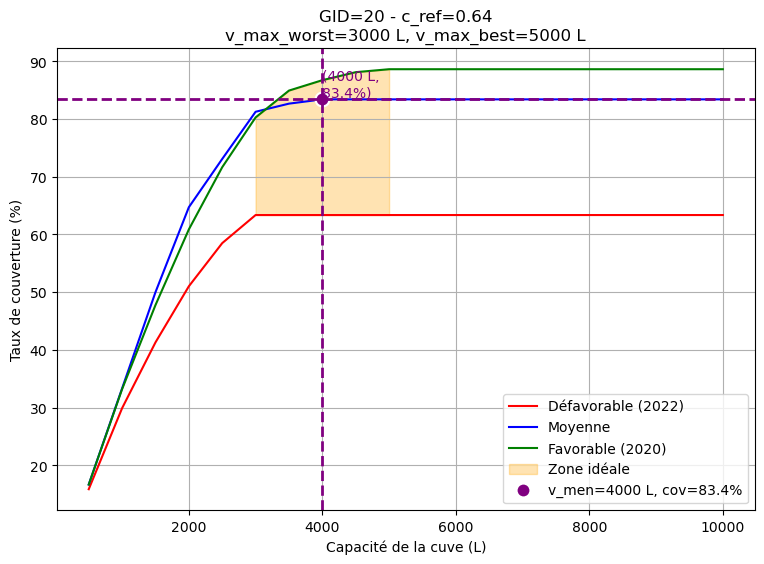

In [28]:
plt.figure(figsize=(9,6))

# Courbes
plt.plot(x_worst, y_worst, color="red",   label=f"Défavorable ({worst_year})")
plt.plot(x_mean,  y_mean,  color="blue",  label="Moyenne")
plt.plot(x_best,  y_best,  color="green", label=f"Favorable ({best_year})")

# Zone [défavorable->favorable], x in [v_max_worst..v_max_best]
mask_w= (x_worst>=v_min_zone)&(x_worst<=v_max_zone)
mask_b= (x_best >=v_min_zone)&(x_best <=v_max_zone)
x_zone_worst= x_worst[mask_w]
y_zone_worst= y_worst[mask_w]
x_zone_best=  x_best[mask_b]
y_zone_best=  y_best[mask_b]

if len(x_zone_worst)== len(x_zone_best):
    # On suppose x_zone_worst == x_zone_best
    x_zone= x_zone_worst
    plt.fill_between(
        x_zone,
        y_zone_worst,
        y_zone_best,
        color="orange",
        alpha=0.3,
        label="Zone idéale"
    )

# Point (v_men, c_men)
plt.plot([v_men],[c_men],'o',
        color="purple", markersize=10,
        markeredgecolor='white', markeredgewidth=1.5,
        label=f"v_men={v_men:.0f} L, cov={c_men:.1f}%")

# Axes
plt.axvline(x=v_men, color="purple", linestyle='--', linewidth=2, ymin=0, ymax=1)
plt.axhline(y=c_men, color="purple", linestyle='--', linewidth=2, xmin=0, xmax=1)

plt.text(
    v_men,c_men,
    f"({v_men:.0f} L,\n{c_men:.1f}%)",
    color='purple', ha='left', va='bottom'
)

plt.xlabel("Capacité de la cuve (L)")
plt.ylabel("Taux de couverture (%)")
plt.title(
    f"GID={gid} - c_ref=0.64\n"
    f"v_max_worst={v_max_worst:.0f} L, v_max_best={v_max_best:.0f} L"
)
plt.grid(True)
plt.legend()
plt.show()


## Conclusion

Selon la norme NF P16-005, on commence par calculer le coefficient de référence : $C_{\text{ref}}$

Si $C_{\text{ref}} \geq 0.65$, le volume idéal de cuve $V_{\text{ref}}$ est directement donné par la formule de la norme.

En revanche, si $C_{\text{ref}} < 0.65$, la méthode de référence ne s’applique plus ; on recourt alors à une simulation plus poussée.

Dans ce second cas :
- On suppose que l’utilisateur connaît sa consommation journalière (ou mensuelle).
- Il a une idée de la capacité minimale et maximale envisageables pour la cuve.
- On simule pas à pas le remplissage et la consommation, pour différentes capacités dans cette plage.

On repère alors la **zone optimale** où le volume de cuve couvre convenablement les besoins, à la fois :
- Pour l’année la plus favorable.
- Pour l’année la plus défavorable.

Cette plage de capacités est visualisée sur le graphique sous forme de **zone optimum**, ce qui permet de déterminer plus précisément le **volume optimum** pour le dimensionnement final de la cuve.
